# Initialization

In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

  ## Факультативное задание

In [ ]:
# Load the datasets
books = pd.read_parquet("./datasets/books.parquet")
interactions = pd.read_parquet("./datasets/interactions.parquet")

In [ ]:
# EDA Tasks

# 1. Count of unique users
user_count = interactions['user_id'].nunique()

In [7]:
# 2. Average number of books read per user
average_books_per_user = interactions.groupby('user_id')['book_id'].nunique().mean()

In [8]:
# 3. Proportion of read books without a rating
read_books_no_rating = interactions[(interactions['is_read'] == True) & (interactions['rating'] == 0)].shape[0]
total_read_books = interactions[interactions['is_read'] == True].shape[0]
proportion_no_rating = read_books_no_rating / total_read_books


In [9]:
# 4. Rating distribution
rating_distribution = interactions['rating'].value_counts(normalize=True).sort_index()


In [10]:
# 5. Popularity distribution (fraction of users per book)
book_popularity = interactions.groupby('book_id')['user_id'].nunique() / user_count


In [11]:
# 6. Interaction count over time
interactions['started_at'] = pd.to_datetime(interactions['started_at'], errors='coerce')
interactions['read_at'] = pd.to_datetime(interactions['read_at'], errors='coerce')
interactions_over_time = interactions.set_index('started_at').resample('M')['user_id'].count()


Total unique users: 542657
Average number of books read per user: 23.75
Proportion of read books without a rating: 8.16%


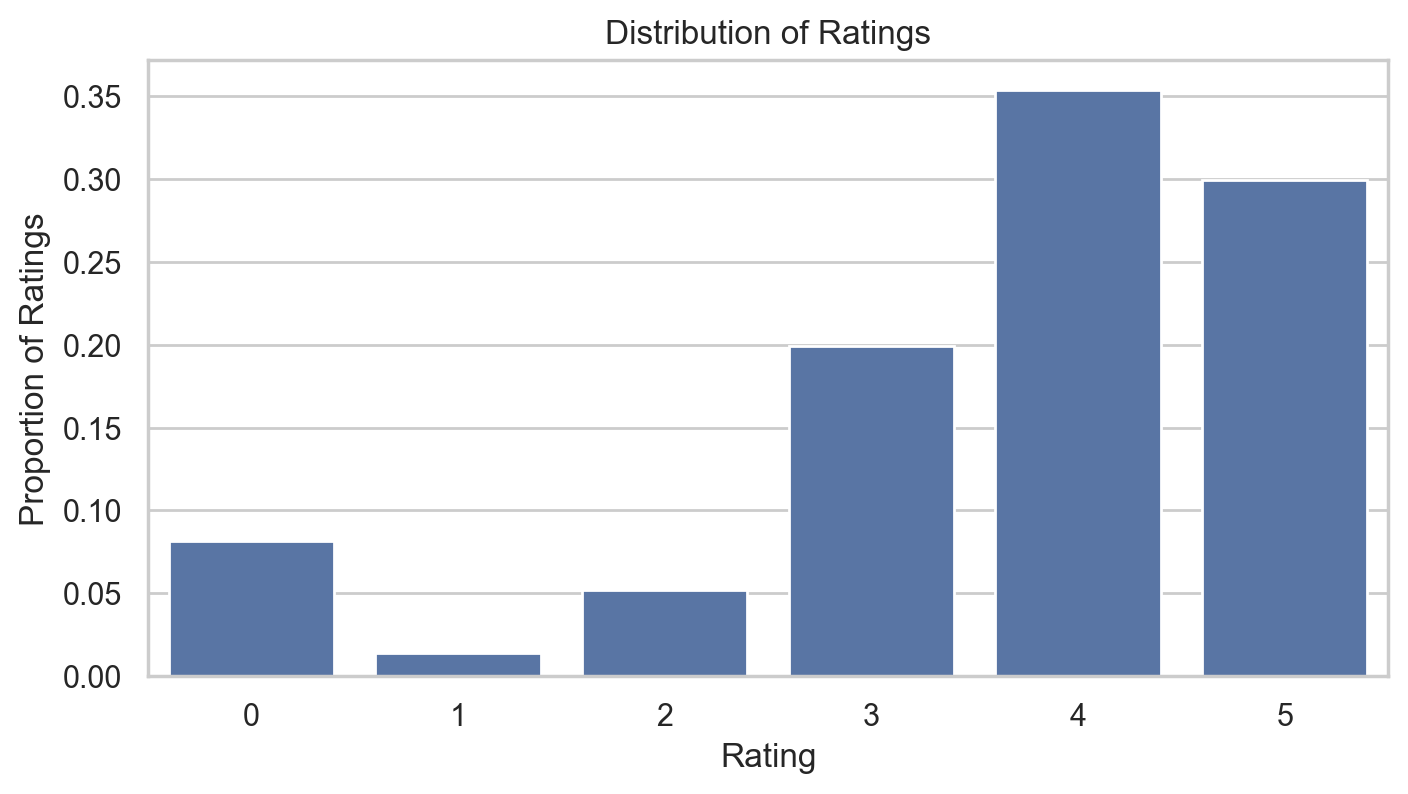

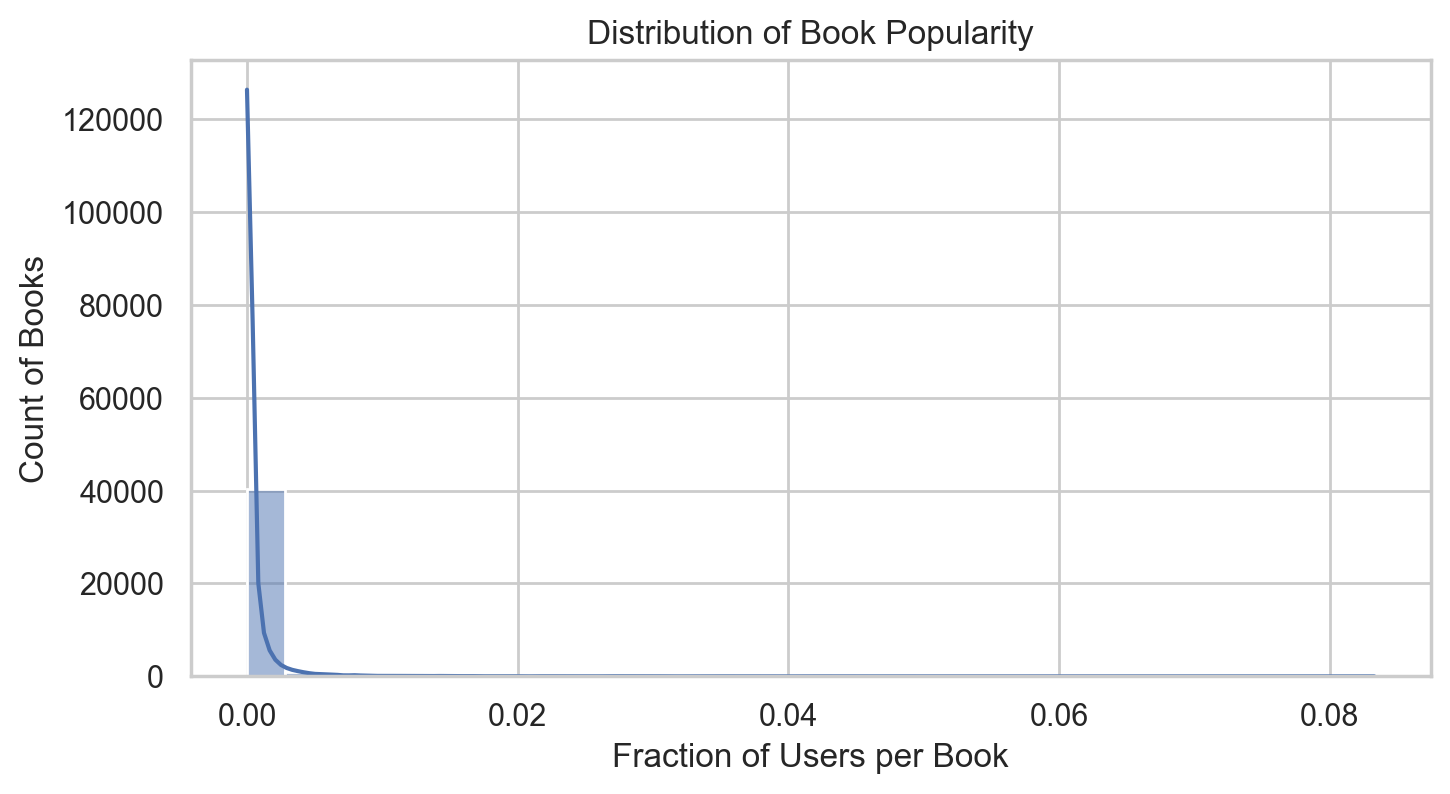

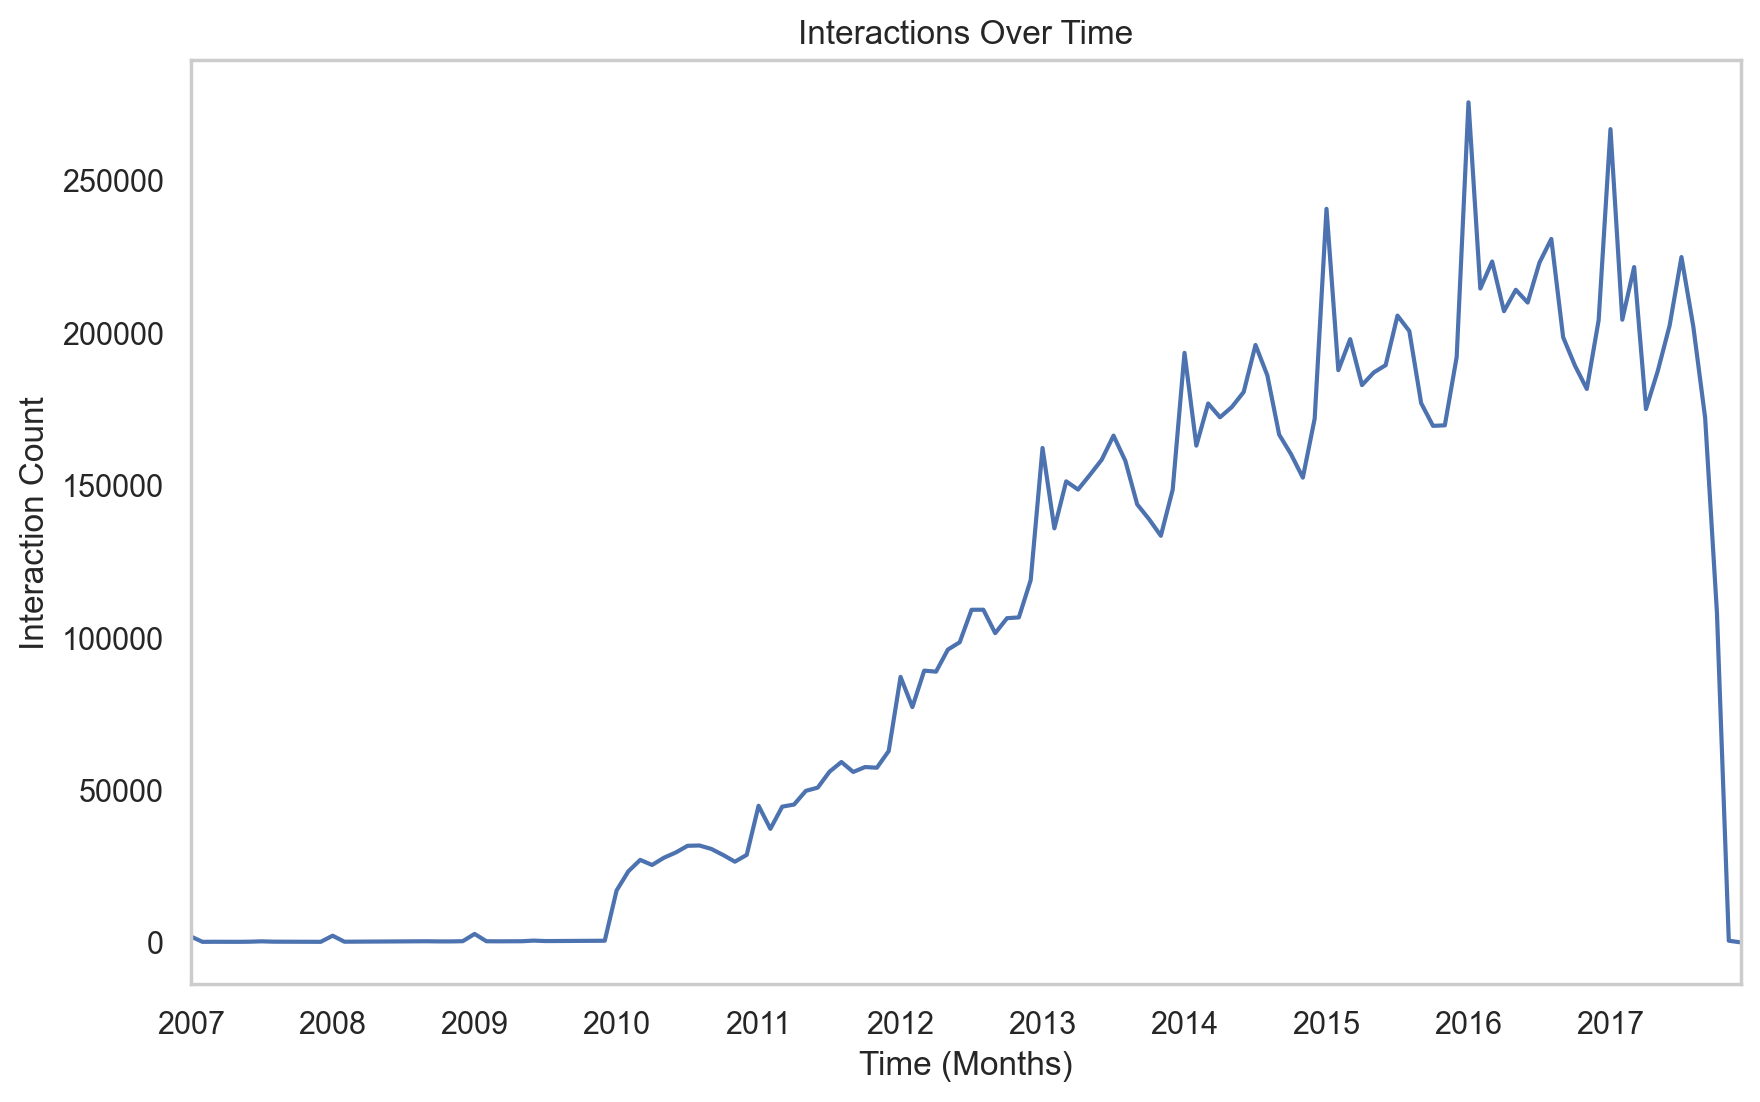

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a theme for Seaborn
sns.set_theme(style="whitegrid")

# 1. Display user count and average books per user
print(f"Total unique users: {user_count}")
print(f"Average number of books read per user: {average_books_per_user:.2f}")

# 2. Display proportion of read books without a rating
print(f"Proportion of read books without a rating: {proportion_no_rating:.2%}")

# 3. Plot rating distribution
plt.figure(figsize=(8, 4))
sns.barplot(x=rating_distribution.index, y=rating_distribution.values)
plt.xlabel("Rating")
plt.ylabel("Proportion of Ratings")
plt.title("Distribution of Ratings")
plt.show()

# 4. Plot book popularity distribution (fraction of users per book)
plt.figure(figsize=(8, 4))
sns.histplot(book_popularity, kde=True, bins=30)
plt.xlabel("Fraction of Users per Book")
plt.ylabel("Count of Books")
plt.title("Distribution of Book Popularity")
plt.show()

# 5. Plot interaction count over time
plt.figure(figsize=(10, 6))
interactions_over_time.plot(kind="line")
plt.xlabel("Time (Months)")
plt.ylabel("Interaction Count")
plt.title("Interactions Over Time")
plt.grid()
plt.show()


# Загрузка данных

In [13]:
items = pd.read_parquet("items.par")
events = pd.read_parquet("events.par")

# Разбиение с учётом хронологии

Рекомендательные системы на практике работают с учётом хронологии. Поэтому поток событий для тренировки и валидации полезно делить на то, что уже случилось, и что ещё случится. Это позволяет проводить валидацию на тех же пользователях, на которых тренировались, но на их событиях в будущем.

# === Знакомство: "холодный" старт

In [ ]:
# Задание 2 из 6

# Define the split date
train_test_global_time_split_date = pd.to_datetime("2017-08-01").date()

# Create a boolean mask for training and testing splits
train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date
events_train = events[train_test_global_time_split_idx]
events_test = events[~train_test_global_time_split_idx]

# Get unique users in train and test sets
users_train = events_train["user_id"].drop_duplicates()
users_test = events_test["user_id"].drop_duplicates()

# Calculate the number of common users between train and test
common_users = users_train[users_train.isin(users_test)]



In [16]:
# Display the counts
print(len(users_train), len(users_test), len(common_users)) 
# Сколько уникальных пользователей есть и в events_train, и в events_test?
# 120858

428220 123223 120858


In [17]:
# Задание 3 из 6

# Identify cold users (users in the test set but not in the training set)
cold_users = users_test[~users_test.isin(users_train)]

# Display the count of cold users
print(len(cold_users))

2365


In [ ]:
# Задание 4 из 6

top_pop_start_date = pd.to_datetime("2015-01-01").date()

item_popularity = events_train \
    .query("started_at >= @top_pop_start_date") \
    .groupby(["item_id"]).agg(users=("user_id", "nunique"), avg_rating=("rating", "mean")).reset_index()

item_popularity["popularity_weighted"] = item_popularity["users"] * item_popularity["avg_rating"]


# Sort by descending weighted popularity
item_popularity = item_popularity.sort_values(by="popularity_weighted", ascending=False)

# Select the top 100 items with an average rating of at least 4
top_k_pop_items = item_popularity.query("avg_rating >= 4").head(100)

# Display the result
top_k_pop_items.head()

# Сколько пользователей оценило книгу, попавшую на первое место в top_k_pop_items?
# 20207

,item_id,users,avg_rating,popularity_weighted
32387,18007564,20207,4.321275,87320.0
32623,18143977,19462,4.290669,83505.0
30695,16096824,16770,4.301014,72128.0
2,3,15139,4.706057,71245.0
3718,38447,14611,4.232770,61845.0


In [20]:
# добавляем информацию о книгах
top_k_pop_items = top_k_pop_items.merge(
    items.set_index("item_id")[["author", "title", "genre_and_votes", "publication_year"]], on="item_id")

with pd.option_context('display.max_rows', 100):
    display(top_k_pop_items[["item_id", "author", "title", "publication_year", "users", "avg_rating", "popularity_weighted", "genre_and_votes"]])

,item_id,author,title,publication_year,users,avg_rating,popularity_weighted,genre_and_votes
0,18007564,Andy Weir,The Martian,2014,20207,4.321275,87320.0,"{'Science Fiction': 11966, 'Fiction': 8430}"
1,18143977,Anthony Doerr,All the Light We Cannot See,2014,19462,4.290669,83505.0,"{'Historical-Historical Fiction': 13679, 'Fict..."
2,16096824,Sarah J. Maas,A Court of Thorns and Roses (A Court of Thorns...,2015,16770,4.301014,72128.0,"{'Fantasy': 14326, 'Young Adult': 4662, 'Roman..."
3,3,"J.K. Rowling, Mary GrandPré",Harry Potter and the Sorcerer's Stone (Harry P...,1997,15139,4.706057,71245.0,"{'Fantasy': 59818, 'Fiction': 17918, 'Young Ad..."
4,38447,Margaret Atwood,The Handmaid's Tale,1998,14611,4.232770,61845.0,"{'Fiction': 15424, 'Classics': 9937, 'Science ..."
5,15881,"J.K. Rowling, Mary GrandPré",Harry Potter and the Chamber of Secrets (Harry...,1999,13043,4.632447,60421.0,"{'Fantasy': 50130, 'Young Adult': 15202, 'Fict..."
6,11235712,Marissa Meyer,"Cinder (The Lunar Chronicles, #1)",2012,14348,4.179189,59963.0,"{'Young Adult': 10539, 'Fantasy': 9237, 'Scien..."
7,17927395,Sarah J. Maas,A Court of Mist and Fury (A Court of Thorns an...,2016,12177,4.730640,57605.0,"{'Fantasy': 10186, 'Romance': 3346, 'Young Adu..."
8,18692431,"Nicola Yoon, David Yoon","Everything, Everything",2015,14121,4.071454,57493.0,"{'Young Adult': 5175, 'Romance': 3234, 'Contem..."
9,5,"J.K. Rowling, Mary GrandPré",Harry Potter and the Prisoner of Azkaban (Harr...,2004,11890,4.770143,56717.0,"{'Fantasy': 49784, 'Young Adult': 15393, 'Fict..."


In [21]:
# Задание 5 из 6

cold_users_events_with_recs = \
    events_test[events_test["user_id"].isin(cold_users)] \
    .merge(top_k_pop_items[["item_id", "avg_rating"]], on="item_id", how="left")  # Left join to get avg_rating where available

cold_user_items_no_avg_rating_idx = cold_users_events_with_recs["avg_rating"].isnull()

cold_user_recs = cold_users_events_with_recs[~cold_user_items_no_avg_rating_idx] \
    [["user_id", "item_id", "rating", "avg_rating"]]

In [ ]:
# Output a sample to verify the transformation
print(cold_user_recs.head())
print(f"Total recommended events for cold users: {len(cold_user_recs)}")


# Верный ответ — 0,8023 (без округления). Книги в top_k_pop_items настолько популярны, 
# что большая часть «холодных» пользователей их читала! Если у вас получилось другое значение, 
# перепроверьте своё решение и убедитесь, что вы считаете долю по cold_user_items_no_avg_rating_idx.

    user_id   item_id  rating  avg_rating
2   1361610  25899336       4    4.427261
5   1338996  16096824       5    4.301014
8   1338996  18692431       5    4.071454
9   1338996  28763485       2    4.194663
15  1276025     38447       5    4.232770
Total recommended events for cold users: 1912


In [ ]:
# Задание 6 из 6

# Import necessary libraries
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate RMSE
rmse = mean_squared_error(cold_user_recs["rating"], cold_user_recs["avg_rating"], squared=False)

# Calculate MAE
mae = mean_absolute_error(cold_user_recs["rating"], cold_user_recs["avg_rating"])

# Print the metrics, rounded to two decimal places
print(round(rmse, 2), round(mae, 2))

# Какое значение метрики MAE получилось? Приведите минимум два знака после запятой.
0.62


0.78 0.62


In [25]:
# посчитаем покрытие холодных пользователей рекомендациями

cold_users_hit_ratio = cold_users_events_with_recs.groupby("user_id").agg(hits=("avg_rating", lambda x: (~x.isnull()).mean()))

print(f"Доля пользователей без релевантных рекомендаций: {(cold_users_hit_ratio == 0).mean().iat[0]:.2f}")
print(f"Среднее покрытие пользователей: {cold_users_hit_ratio[cold_users_hit_ratio != 0].mean().iat[0]:.2f}")

Доля пользователей без релевантных рекомендаций: 0.59
Среднее покрытие пользователей: 0.44


# === Знакомство: первые персональные рекомендации

# === Базовые подходы: коллаборативная фильтрация

# === Базовые подходы: контентные рекомендации

# === Базовые подходы: валидация

# === Двухстадийный подход: метрики

# === Двухстадийный подход: модель

# === Двухстадийный подход: построение признаков